<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/mirna_binding/blob/master/notebook/model_train_lock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Python Modules

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from multiprocessing import Pool
from functools import partial
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

## Data Preprocessing

### Download the pre-processed ENCORI dataset.

The Encori Dataset was obtained by downloading the whole dataset through the
Encori API at [URL](http://www.sysu.edu.cn/403.html).

The dataset is divided into train and test set:

- test set is represented by samples mapping on chromosome 1  
- train set can be represented by any of the samples except those mapping on chromosome 1  

The train set should be made of a total number of 179148 samples.

The cell below downloads the train set from the project folder on Github.

The train set corresponds to ENCORI samples not mapping on chromosome 1.

In [ ]:
!wget https://github.com/ML-Bioinfo-CEITEC/mirna_binding/raw/master/data/datasets/train_set_positives.tar.xz
!tar -xvf train_set_positives.tar.xz

--2021-11-03 08:36:18--  https://github.com/ML-Bioinfo-CEITEC/mirna_binding/raw/master/data/datasets/train_set_positives.tar.xz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/mirna_binding/master/data/datasets/train_set_positives.tar.xz [following]
--2021-11-03 08:36:19--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/mirna_binding/master/data/datasets/train_set_positives.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6693928 (6.4M) [application/octet-stream]
Saving to: ‘train_set_positives.tar.xz’

train_set_positives 100%[===================>]   6.38M  32.2MB/s

## General notebook functions

A set of functions used to generate a one hot encoding version of the sequences and dot matrix.

### Convert the input nucleotide sequences to arrays.

The code below takes as an input a table of three columns:

- genomic binding site ( 50nt length);
- microRNA sequence (20nt length);
- label: class [ positive or negative ];

It outputs a list of arrays as:

1. 2d matrix of binding vs microRNA with 2 channels. The first channel is watson-crick score, the second channel is relative position of microRNA (or zero if not required).
2.  Binding site sequence as tensor of shape 50 x 4, where each channel is a nucleotide.
3.  MicroRNA sequence as tensor of shape 20 x 4, where each channel is a nucleotide.
4.  Labels: numpy array [ 0 or 1, as negatie or positive].


In [ ]:
def one_hot_encoding(df, tensor_dim=(50,20,1), categories=False):
    """
    fun transform input database to one hot encoding numpy array.
    
    parameters:
    df = Pandas df with col names "binding_sequence", "label", "mirna_binding_sequence"
    tensor_dim= 2d matrix shape
    
    output:
    2d dot matrix, labels as np array
    """

    # reset df indexes (needed for multithreading)
    df.reset_index(inplace=True, drop=True)

    # alphabet for watson-crick interactions.
    alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1.} 

    # labels to one hot encoding
    if "label" in df.columns:
        if categories:
            labels = pd.get_dummies(df["label"])
        else:
            labels = np.where(df["label"] == 'positive', 1, 0)
    else:
        labels = None
    # create empty main 2d matrix array
    N = df.shape[0] # number of samples in df
    shape_matrix_2d = (N, *tensor_dim) # 2d matrix shape 
    # initialize dot matrix with zeros
    ohe_matrix_2d = np.zeros(shape_matrix_2d, dtype="float32")

    # compile matrix with watson-crick interactions.
    for index, row in df.iterrows():        
        for bind_index, bind_nt in enumerate(row.binding_sequence.upper()):
        
            for mirna_index, mirna_nt in enumerate(
                row.mirna_binding_sequence.upper()
                ):

                base_pairs = bind_nt + mirna_nt
                # 
                ohe_matrix_2d[index, bind_index, mirna_index, 0] = alphabet.get(base_pairs, 0)
    

    return ohe_matrix_2d, labels

### Parallelized conversion of an array/dataframe to 2D matrix

The function bellow takes as an input a Pandas df or numpy array and splits it into batches for parallelization.

Usage:

`output = multithread(df, one_hot_encoding, aux=False, log=False, n_cores=24)`  
`data = join_cores_results(output, aux=True)`

In [ ]:
def join_cores_results(multithread_output):
    """
    join the output of different core processes 
    
    paramenters:
    multithread_out=

    returns:
    concateneted array_2d_matrix and labels of all jobs
    """
    array_2d_matrix = np.concatenate(
        [ process[0] for process in multithread_output ]
    )
    array_labels = np.concatenate(
    [ process[1] for process in multithread_output ]
    )
    return array_2d_matrix, array_labels

In [ ]:
def multithread(df, func, n_cores=4):
    """
    split input dataset into equal parts and parallelize function

    paramenters:
    df=input Pandas dataframe
    fun=applied function
    n_cores=number of cores (def.4)
    """
    iterable = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    lock_func = partial(func)
    df_update = pool.map(lock_func, iterable)
    pool.close()
    pool.join()
    data = join_cores_results(df_update)
    return data

### Subsample the positive class from the main training set.

In [ ]:
def positive_sample_generator(df, size, random_state=None, reduce=True):
    """
    random sampling of N samples from main dataframe.

    paramenters:
    df=Pandas dataframe
    size=number of samples to extract (int.)
    random_state=fix seed (int., def. None)
    reduce=remove subsamples from main df (bool, def. True)

    returns:
    positive samples as Pandas dataframe and original dataframe
    """

    #copy input df
    X = df.copy()
    positive_samples = X.sample(
        n=size, random_state=random_state
        ).copy()

    to_drop = [ name for name in X.columns
               if name not in [
                    'mirna_binding_sequence', 'binding_sequence', 'label']
               ]
    positive_samples.drop(
            to_drop, axis=1, inplace=True
            )
    if reduce:
        df = X.drop(positive_samples.index, axis=0, inplace=False
            ).reset_index(drop=True)
    return positive_samples, df

### Shuffle the positive class to create the negative one.

The function generates the negative class by creating a connection between each

binding site and all mirna (expect the real one). If argument mirna_dict is

provided as dictionary of mirna sequences, this dictionary will be used to

create the negative class. Otherwise, all unique mirna sequences of the input

df will be used to generate samples for the negative class.

In [ ]:
def negative_class_generator(df, mirna_list=None, neg_ratio=None,
                             random_state=None):
    """
    random generation of negative samples.

    paramenters:
    df=Pandas dataframe
    mirna_list=list of unique mirna sequences (list)
    neg_ratio=sampling N samples from each negative connections (int.)
    random_state=fix seed (int.)

    returns:
    negative samples as Pandas dataframe
    """
    if not mirna_list:
        # generate mirna db of unique sequences
        mirnadb = pd.DataFrame(
            df.mirna_binding_sequence.unique(), columns=['mirnaid']
        )
    else:
        mirnadb = pd.DataFrame(mirna_list)
        mirnadb.columns = ['mirnaid']
    # add mirna db to each row of df
    connections = mirnadb.assign(key=1).merge(
          df.assign(key=1), on='key'
          ).drop(['key', 'label'],axis=1)

    # # find index of positive connection
    positive_samples_mask = (connections.mirnaid == 
                             connections.mirna_binding_sequence)
    # # drop positive connection to create negative samples
    negative_df = connections[~positive_samples_mask].copy().drop(
      ['mirna_binding_sequence'], axis=1
      ).reset_index(drop=True)
    # # rename cols
    negative_df.columns = ['mirna_binding_sequence', 'binding_sequence']
    # # add negative labels
    negative_df['label'] = 'negative'
    if neg_ratio == None:
        return negative_df
    else:
        neg_samples = int(df.shape[0] * neg_ratio)
        return negative_df.sample(n=neg_samples, random_state=random_state)

### Generate dataset for training.

In [ ]:
def generate_subsets(
    df=None, size=None, neg_ratio=None, pos_df=None,
    update=False, random_state=None, mirna_list=None
    ):
    """
    complete or partial replacement of training dataset;

    paramenters:
    df=Pandas df with all positive samples (def.None)
    size=number of samples to subset from df (int., def.None)
    neg_ratio=retio of negatives to be generated (int., def.None)
    pos_df=subset of positive samples (Pandas df, def.None)
    update=complete (True) or partial (False) replacement (bool, def.False)
    
    returns:
    pos_df, neg_df, df
    """
    if update:
        pos_df, df = positive_sample_generator(
            df, size, random_state=random_state
            )
    neg_df = negative_class_generator(
        pos_df, neg_ratio=neg_ratio,
        random_state=random_state, mirna_list=mirna_list
        )
    return pos_df, neg_df, df


### Create Hand-Picked Mini-Batches.

The function creates minibatches keeping the original positive-negative ratio 

and returns a list of minibatches (pos + neg together).

# Data viz

## Heatmaps

In [ ]:
import pprint
from collections import defaultdict

def make_heatmaps(
    df_one,
    labels_cat=None,
    labels_cat_names=None,
    pred_score=None,
    size=None,
    index=None):
    if size:
        random_sampling = np.random.choice(labels_cat.shape[0], size=size)
    elif isinstance(index, np.ndarray):
        random_sampling = index
    elif index:
        random_sampling = np.array(index)
    else:
        random_sampling = np.random.choice(labels_cat.shape[0], size=4)
    if isinstance(pred_score, np.ndarray):
        score_val = defaultdict(str)
    if len(random_sampling) != 1:
        fig, ax = plt.subplots(1, random_sampling.shape[0])
        for i, index in enumerate(random_sampling):
            cat_index = labels_cat[index]
            cat_name = labels_cat_names[cat_index]
            if isinstance(pred_score, np.ndarray):
                score = np.take(pred_score, indices=[index], axis=0)
                score_val[index] = score
            else:
                score = None
            ax[i].title.set_text(f'cat:{cat_name[:3]}|{cat_index}|{index}')
            ax[i].imshow(df_one[index].squeeze(), cmap='Blues')
    else:
        fig, ax = plt.subplots(1, 1, figsize=(100,100))
        cat_index = labels_cat[index]
        cat_name = labels_cat_names[cat_index]
        if isinstance(pred_score, np.ndarray):
            score = np.take(pred_score, indices=[index], axis=0)
            score_val[index] = score
        else:
            score = None
        ax.title.set_text(f'cat:{cat_name[:3]}|cat_i{cat_index}|i:{index}')
        ax.imshow(df_one[index].squeeze(), cmap='Blues')
    if isinstance(pred_score, np.ndarray):
        pprint.pprint(score_val, width=1)
    return(None)

In [ ]:
def make_minibatches(pos_samples, neg_samples, split_batch, log=None):
    """
    split positive and negative samples dataframes into minibatches. This
    function keeps the positive vs negative ratio within each batch.

    paramenters:
    pos_samples=Pandas df with all positive samples (def.None)
    neg_samples=Pandas df with all negative samples (def.None)
    split_batch=split dataset into N parts (int.)
    
    returns:
    A list where each element is a minibatch
    """
    
    batches_list = []
    ## split subset_pos.class into minibatches
    ### see numpy doc for more details:
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html
    batch_pos = np.array_split(pos_samples, split_batch)
    ## split subset_neg into minibatches
    ## of size == SPLIT_BATCH
    batch_neg = np.array_split(neg_samples, split_batch)
    ## zip together pos and neg subsets to create minibatches
    for mini_index, minibatch_pairs in enumerate(zip(batch_pos, batch_neg)):
        if log:
            print(
                    '### minibatch pair id is:',
                    mini_index,
                    'pos-neg shapes are:',
                    minibatch_pairs[0].shape[0],
                    minibatch_pairs[1].shape[0],
                    sep='\t'
                    )
        batch_train = pd.concat(minibatch_pairs)
        # append each minibatch to minibatch list
        batches_list.append(batch_train)
    return batches_list

# Build the Model.

### Load TensorFlow and modules.

In [ ]:
from tensorflow import keras as keras 
from tensorflow.keras.layers import (
                                BatchNormalization, LeakyReLU,
                                Input, Dense, Conv2D,
                                MaxPooling2D, Flatten, Dropout)

from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

### Model architecture:

In [ ]:
def make_arch_00b(output_shape):
    """
    build model archietecture as described in the manuscript.

    return a model object
    """
    main_input = Input(shape=(50,20,1),
                       dtype='float32', name='main_input'
                       )

    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_1")(main_input)    
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_1')(x)
    x = Dropout(rate = 0.25)(x)

    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_2")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_2')(x)
    x = Dropout(rate = 0.25)(x)

    x = Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        data_format="channels_last",
        name="conv_3")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_3')(x)
    x = Dropout(rate = 0.25)(x)

    conv_flat = Flatten(name='2d_matrix')(x)

    x = Dense(128)(conv_flat)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate = 0.25)(x)

    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate = 0.25)(x)

    x = Dense(32)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate = 0.25)(x)

    if output_shape == 1:
      main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    else:
      main_output = Dense(2, activation='softmax', name='main_output')(x)

    model = Model(inputs=[main_input], outputs=[main_output], name='arch_00b')
    
    return model

In [ ]:
def compile_model(output_shape):
    K.clear_session()
    if output_shape == 1:
      loss = 'binary_crossentropy'
    else:
      loss = 'categorical_crossentropy'
    model = make_arch_00b(output_shape)
    opt = Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam")

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=['accuracy']
        )
    return model

### Training and evaluation functions:

In [ ]:
def train(
    model, minibatch,
    reset_metrics=True,
    save=False,
    fname=None
    ):
    """
    train model on selected minibatch.
    Doc. at https://keras.io/api/models/model_training_apis/.

    paramenters:
    model=compiled Keras model
    minibatch=set of X_train and labels
    reset_metrics=If True, the metrics returned will be only for this batch.
    If False, the metrics will be statefully accumulated across batches.
    save=save model (bool, Def.False)
    fname=model file name

    returns:
    trained model, batch loss
    """

    X_ohe, y_ohe = minibatch  
    model_loss = model.train_on_batch(
        { "main_input" : X_ohe},
        { "main_output" : y_ohe},
        reset_metrics=reset_metrics
        )

    if save:
        model.save(fname)
    return model, model_loss

In [ ]:
def eval_f1(
    model, minibatch, pos_thr=0.5, save=False, fname=None, test=False
    ):
    """
    generate F1 score for the current minibatch
    
    paramenters:
    model=trained model
    minibatch=tuple of X and labels
    pos_thr=threshold for positive class
    save=save model if above f1 threshold (bool, Def.False)
    fname=model file name

    returns:
    f1 score
    """
    X, y_true = minibatch
    if test:
        y_pred = model.predict({'main_input' : X}, batch_size=32)
    else:
        y_pred = model.predict_on_batch({ "main_input" : X})
    
    y_pred_class = np.where(y_pred > pos_thr, 1, 0)
    f1 = f1_score(y_true, y_pred_class)
    return f1

# In-Silico Modelling
This section generates an in-silico miRNA to model known miRNA binding rules.

## Load the ENCORI DB.

In [ ]:
ENCORI_PATH = './train_set_positives.tsv'

np.random.seed(1789)

train_df = pd.read_csv(
    ENCORI_PATH, sep='\t',
    usecols=['familyseqRepresentative', 'pos_sequence'])
train_df.columns = [
                    'binding_sequence',
                    'mirna_binding_sequence'
                    ]
mirna_db_encori = train_df.mirna_binding_sequence.unique().tolist()
mirna_db_encori_train, mirna_db_encori_test = train_test_split(
    mirna_db_encori, train_size=0.8)


print(f'extracted {len(mirna_db_encori)} unique mirna sequences')

extracted 407 unique mirna sequences


## Define random mutation function.
This function randomly mutates specific nucleotides upon probability threshold.

In [ ]:
import random
import itertools

def random_mutation(input_seq,
                    end_mut, 
                    start_mut, 
                    p=0.5, 
                    nt_mut_prob="", 
                    alphabet=np.array(list("ACGT"))):
    ''''
    function takes as input a random sequence, 
    and mutate the user defined area.

    paramenters:
    input_seq=a nucleotide sequence (str)
    mut_area=num index (int)
    p=probability of mutation [0,1] (float)
    nt_mut_prob=np array of mutation probability of each base
    alphabet = nt alphabet from which pick mutation

    returns:
    mutated sequence (str)
    '''
    assert (end_mut <= len(input_seq)), "end_mut > len(sequence)"
    assert (p <= 1.), "prob mutation > 1"
    assert (start_mut != 0), "index starts from 1, then it is corrected to python index"
    start_mut = start_mut - 1
    # set nt mut prob if not provided
    if nt_mut_prob == "":
        std_value = 1/alphabet.shape[0]
        nt_mut_prob = np.full(alphabet.shape, fill_value=std_value)

    # convert input_set to list
    out_seq = list(input_seq)
    # mutate and replace
    mutated_string = ""
    mut_prob_array = np.random.random(size=end_mut - start_mut)
    for index, i in enumerate(out_seq[start_mut : end_mut]):
        if mut_prob_array[index] >= 1. - p:
            mutated_nt = np.random.choice(alphabet, p=nt_mut_prob)
            while mutated_nt == i:
                mutated_nt = np.random.choice(alphabet, p=nt_mut_prob)
            else:
                mutated_string += mutated_nt
        else:
            mutated_string += i
    out_seq[start_mut : end_mut] = mutated_string
    # list to string
    out_seq = ''.join(out_seq)
    assert (len(input_seq) == len(out_seq)), "input and output sequences have different length"
    return(out_seq)

## run example
seq_input_ = ["AAAAAGGGGGGCCCCCC", "AAACGATCGAAAGGGGG"]
mirna_db_mut_ = [random_mutation(
    i, start_mut=7, end_mut=10, p=1.) 
                        for i in seq_input_]
# show some mutated sequences
for i in range(len(seq_input_)):
    mut_pos = ''.join([ "|" if mirna_db_mut_[i][ii] ==  seq_input_[i][ii] else "." 
                       for ii in range(len(seq_input_[i]))]) 
    print(f'{mirna_db_mut_[i]} mut\n{mut_pos}\n{seq_input_[i]} wt\n')


AAAAAGAACCGCCCCCC mut
||||||....|||||||
AAAAAGGGGGGCCCCCC wt

AAACGAGGAGAAGGGGG mut
||||||....|||||||
AAACGATCGAAAGGGGG wt



This function generates a random set of in-silico miRNA-binding site connections.

In [ ]:
from collections import defaultdict

def in_silico_connection(
    mirna_wt=None,
    mirna_len=None,
    seq_wt=None, 
    seq_len=None, 
    nest=None, # can be wt or mut (str);
    alphabet=np.array(list("ACGT")),
    nt_mut_prob="",
    nest_at=None,
    nest_to=None,
    end_mut = None, 
    start_mut = None, 
    p_mut=None
    ):
    def comp_rev(sequence):
        alphabet = {"A" : "T", "C" : "G", "T" : "A", "G" : "C", "N" : "N"}
        comprev = [alphabet[i] for i in list(sequence)][::-1]
        return(comprev)
    seq_info = defaultdict()
    # set nt mut prob if not provided
    if nt_mut_prob == "":
        std_value = 1/alphabet.shape[0]
        nt_mut_prob = np.full(alphabet.shape, fill_value=std_value)

    if seq_len and not seq_wt:
        assert seq_len, "need seq_wt != None"
        seq_wt = [
                  np.random.choice(alphabet, p=nt_mut_prob) 
                  for i in range(seq_len)]
        seq_wt = ''.join(seq_wt)
        assert (len(seq_wt) == seq_len), "create seq: seq_wt len != input seq_len"

    if mirna_len and not mirna_wt:
        assert mirna_len, "need mirna_len != None"
        mirna_wt = [
                     np.random.choice(alphabet, p=nt_mut_prob) 
                    for i in range(mirna_len)]
        mirna_wt = ''.join(mirna_wt)        
        assert (len(mirna_wt) == mirna_len), "mirna_seq len != input mirna_len"
    mirna_mut = None
    if nest != None:
        if nest == 'wt':
            nest_mirna = mirna_wt
            assert mirna_wt, "need mirna_seq"
        elif nest == 'mut':
            assert start_mut, 'provide start_mut position'
            #assert end_mut, 'provide end_mut position'
            mirna_mut = random_mutation(
                mirna_wt,
                end_mut = end_mut, 
                start_mut = start_mut, 
                p=p_mut)
            assert mirna_mut, "need mirna_mut"
            nest_mirna = mirna_mut

        assert seq_wt, "need seq_wt"
        mirna_len, seq_len, seq_tmp = len(nest_mirna), len(seq_wt), list(seq_wt)
        if not nest_at:
            nest_at = random.randint(0, seq_len - mirna_len)
        if not nest_to:
            nest_to = nest_at + mirna_len  
        mirna_revcomp = comp_rev(nest_mirna)
        seq_mut = seq_tmp[:nest_at] + mirna_revcomp + seq_tmp[ nest_to : ]
        seq_mut[nest_at : nest_to] = mirna_revcomp
        seq_mut = ''.join(seq_mut)
        assert len(seq_wt) == seq_len, f'nest mirna: seq_wt len != input seq_len | {seq_wt} and {seq_len} {nest_at} {nest_to}'
    seq_info['mirna_mut'] = mirna_mut
    seq_info['seq_wt'] = seq_wt
    seq_info['mirna_wt'] = mirna_wt
    seq_info['nest_at'] = nest_at
    seq_info['nest_to'] = nest_to
    seq_info['seq_mut'] = seq_mut
    seq_info['mirna_revcomp'] = ''.join(mirna_revcomp)

    return(seq_info)

mirna_in = "TAAAAAAAAG"
seq_in = "TACAGAAGAGACTGGCAGGGCACTAATGATAGTCGAGTCCCCACTGTTCG"

seq_info = in_silico_connection(
    mirna_wt=mirna_in,
    mirna_len=20,
    seq_len=50, 
    seq_wt=seq_in, 
    nest='mut',
    start_mut=5,
    end_mut=8,
    alphabet=np.array(list("ACGT")),
    nt_mut_prob="",
    p_mut=1.,
    nest_at=2
    )

print(seq_info['mirna_wt'] == mirna_in)
print(seq_info['mirna_mut'] == mirna_in)

print(seq_info['seq_wt'] == seq_in)
print(seq_info['mirna_revcomp'] in seq_info['seq_mut'])
print(seq_info['seq_mut'][seq_info['nest_at']:seq_info['nest_to']] == seq_info['mirna_revcomp'])

True
False
True
True
True


## Generate the datasets.
Run scripts to create wt and mutated connections.

In [ ]:
# expand 
n_ = 1000 # connections per microrna
seq_len = 50 # length of output sequence
mirna_n = 50 # sample/generate n in-silico mirna
neg_ratio = 1 # warn: neg_ratio != 1 >> class imbalance
# generate n in-silico mirna
# mirna_silico_wt = [in_silico_connection(mirna_len=20)[0] 
#                    for i in range(mirna_n)]
df_list = list()
# use read mirna
random.seed(1789)
mirna_db_wt = random.sample(mirna_db_encori_train, k=mirna_n)

# generate n random connections, WITH nest option set to TRUE:
# the microrna sequence will be nested within the in-silico binding sequence
train_db_samples = [ in_silico_connection(
                            mirna_wt=i,
                            seq_len=50,
                            nest='mut',
                            end_mut = 20, 
                            start_mut = 7, 
                            p_mut=1.)
                        for i in mirna_db_wt for n in range(n_) 
                        ]

connection_silico_wt = pd.DataFrame([ [i['mirna_wt'], i['seq_mut']] 
                                     for i in train_db_samples ], 
                                    columns=[
        'mirna_binding_sequence','binding_sequence']
        ) 
# add labels
connection_silico_wt["label"] = "positive"
#connection_silico_negative_shuffle["label"] = "negative"

connection_silico_negative_shuffle = negative_class_generator(
     connection_silico_wt, 
     mirna_list=mirna_db_encori,
     neg_ratio=neg_ratio
     )

assert (
    connection_silico_negative_shuffle.shape[0] == connection_silico_wt.shape[0] * neg_ratio
    ), "negative class generator error"



## Convert to one hot encoding.

Convert both wt and mut connections to one hot encoding

to generate a 2d matrix.

In [ ]:
comb_df = pd.concat([
                     connection_silico_wt,
                     connection_silico_negative_shuffle]
                    )

df_one, labels_ohe = one_hot_encoding(
    comb_df, tensor_dim=(50,20,1), categories=True)

labels_cat = np.argmax(labels_ohe.to_numpy(), axis=1)
labels_cat_names = labels_ohe.columns

Display the examples of mirna-binding site rendering.

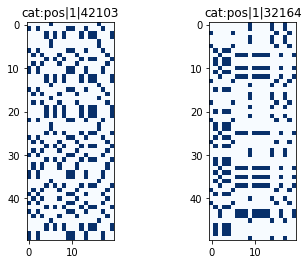

In [ ]:
make_heatmaps(
    df_one=df_one,
    labels_cat=labels_cat,
    labels_cat_names=labels_cat_names,
    size=2)

## Train on the in-silico data.

In [ ]:
model_id = '01'
model = compile_model(output_shape=2)
model.summary()

Model: "arch_00b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 50, 20, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 50, 20, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 20, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 20, 32)        128       
_________________________________________________________________
Max_1 (MaxPooling2D)         (None, 25, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 10, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 25, 10, 64)        184

## Train test split.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_one, labels_ohe,
    test_size = 0.1,
    random_state=1789)

## Train the model.

In [ ]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

model_loss = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    callbacks=my_callbacks
)    

Epoch 1/50
2391/2391 [==============================] - 251s 104ms/step - loss: 0.2388 - accuracy: 0.8947 - val_loss: 0.0338 - val_accuracy: 0.9907
Epoch 2/50
2391/2391 [==============================] - 254s 106ms/step - loss: 0.0594 - accuracy: 0.9841 - val_loss: 0.0317 - val_accuracy: 0.9913
Epoch 3/50
2391/2391 [==============================] - 255s 107ms/step - loss: 0.0444 - accuracy: 0.9891 - val_loss: 0.0259 - val_accuracy: 0.9936
Epoch 4/50
2391/2391 [==============================] - 257s 107ms/step - loss: 0.0376 - accuracy: 0.9916 - val_loss: 0.0219 - val_accuracy: 0.9953
Epoch 5/50
2391/2391 [==============================] - 252s 106ms/step - loss: 0.0331 - accuracy: 0.9924 - val_loss: 0.0238 - val_accuracy: 0.9952
Epoch 6/50
2391/2391 [==============================] - 254s 106ms/step - loss: 0.0276 - accuracy: 0.9933 - val_loss: 0.0209 - val_accuracy: 0.9951
Epoch 7/50
2391/2391 [==============================] - 256s 107ms/step - loss: 0.0238 - accuracy: 0.9945 - val_

## Evaluate the model on the in-silico data.

In [ ]:
from sklearn import metrics
predict = model.predict(X_test)
if predict.shape[1] != 2:
    predict_cat = np.where(predict > 0.5, 1, 0)
    y = y_test
else:
    predict_cat = np.argmax(predict, axis=1)
    y = np.argmax(y_test.to_numpy(), axis=1)
fpr, tpr, thresholds = metrics.roc_curve(y, predict_cat)
print(f'AUC is:\t{metrics.auc(fpr, tpr)}')
print(metrics.classification_report(y, predict_cat))

AUC is:	0.9961762930167036
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4969
           1       0.99      1.00      1.00      5031

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
keras.models.save_model(
    model,f'./model_in_silico_moving_seed_db_{model_id}.h5', 
    overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

## Model interpretation of the in-silico data.



### Create wild type dataset.

A wild-type in-silico dataset is generated and the score is predicted by the model "./model_in_silico.h5".

In [ ]:
# set seed
np.random.seed(1789)
# set N of microRNA to test
mirna_n = 1
#mirna_len = 20
# set binding seq length
seq_len = 50
# sample a mirna
mirna_db_wt = np.random.choice(mirna_db_encori_test, size=mirna_n)
# number of samples (connections)
n_ = 500
neg_ratio = 1

#print('selected mirna are:\n', '\n'.join(mirna_db_wt))
test_db_samples = [ in_silico_connection(
                            mirna_wt=i,
                            seq_len=50,
                            nest='mut',
                            end_mut = 20, 
                            start_mut = 7, 
                            p_mut=1.)
                        for i in mirna_db_wt for n in range(n_) 
                        ]


connection_silico_wt = pd.DataFrame([ [i['mirna_wt'], i['seq_mut']] 
                                     for i in test_db_samples ], 
                                    columns=[
        'mirna_binding_sequence','binding_sequence']
        )
# add labels
connection_silico_wt["label"] = "positive"

# replace mutated mirna with wt if testing for seed
#connection_silico_wt.mirna_binding_sequence = mirna_db_wt[0] # if mirna wt number == 1
# generate negative class
connection_silico_negative_shuffle = negative_class_generator(
     connection_silico_wt, 
     mirna_list=mirna_db_encori_test,
     neg_ratio=neg_ratio)

test_set = pd.concat([connection_silico_wt, connection_silico_negative_shuffle])
#convert to one hot encoding
X_wt, y_cat = one_hot_encoding(
        test_set, tensor_dim=(50,20,1), categories=True)

# convert to 1d if categories
labels_cat = np.argmax(
    y_cat.to_numpy(),
    axis=1)

In [ ]:
from sklearn import metrics
predict = model.predict(X_wt)
predict_cat = np.argmax(predict, axis=1)
fpr, tpr, thresholds = metrics.roc_curve(labels_cat, predict_cat)
print(f'AUC is:\t{metrics.auc(fpr, tpr)}')
target_names = ["negative", "positive"]
print(metrics.classification_report(labels_cat, predict_cat, target_names=target_names))

AUC is:	0.996
              precision    recall  f1-score   support

    negative       1.00      0.99      1.00       500
    positive       0.99      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## find miss labeled samples

In [ ]:
failed_pred = np.where(predict_cat!=labels_cat)[0]

labels_cat[failed_pred]

array([1, 0, 0, 0])

## print out miss labeled samples

defaultdict(<class 'str'>,
            {399: array([[0.5972693 , 0.40273073]], dtype=float32),
             516: array([[0.49150756, 0.50849247]], dtype=float32),
             584: array([[0.00766899, 0.992331  ]], dtype=float32),
             776: array([[0.02041431, 0.9795857 ]], dtype=float32)})


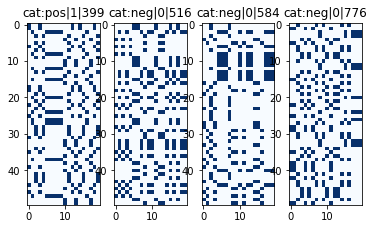

In [ ]:
if failed_pred.shape[0] > 4:
    show_n = np.random.choice(failed_pred, size=4)
else:
    show_n = failed_pred
make_heatmaps(
    df_one=X_wt,
    pred_score=predict,
    labels_cat=labels_cat,
    labels_cat_names=y_cat.columns,
    index=show_n)

# defaultdict stores model predictions - 1st col is neg class.

### Testing code for seed model
generates random mutation nt by nt along the binding site, taking and nesting the mirna within the in-silico random sequence. The model was trained on seed-only binding site.

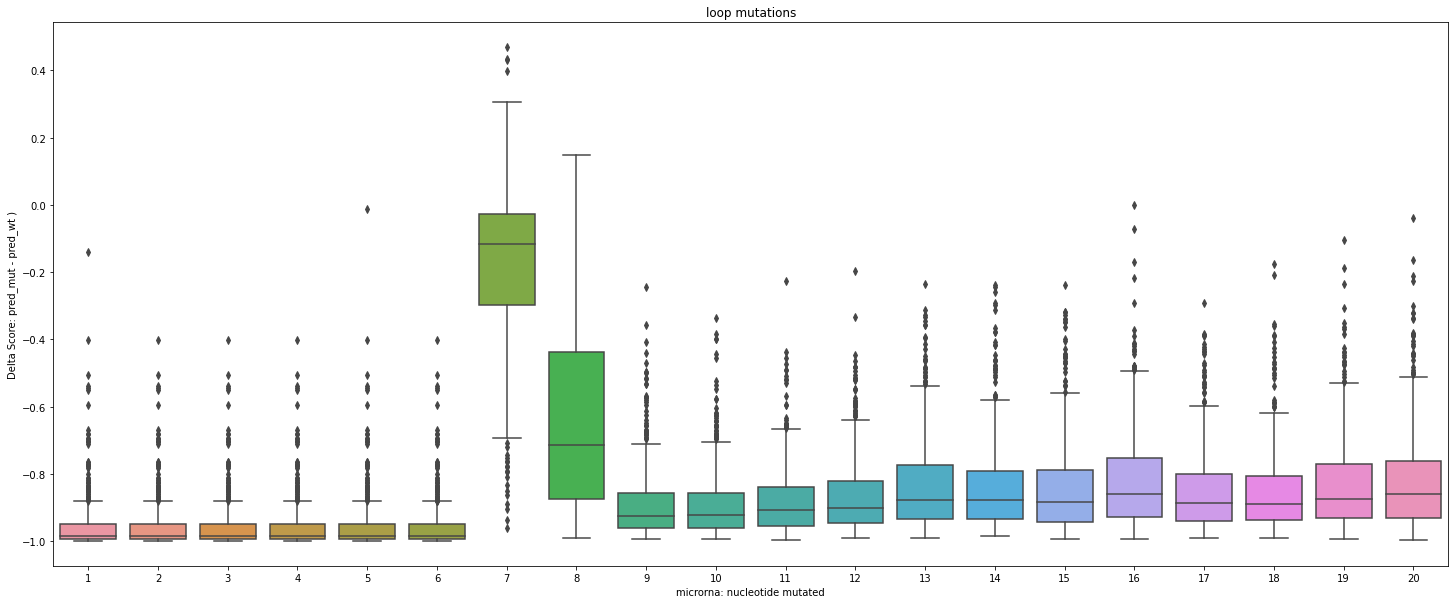

In [ ]:
from matplotlib import pyplot
np.seterr(divide = 'ignore') 
# check class
class_index = 1 # if 1 for + and 0 for -
predict_wt = predict[ : , class_index][np.where(labels_cat == class_index)]
pred_scores = list()
mutate_all = True
for save_nt in range(1, 2 ):
    predictions = list()

    for nucleotide in range(1, 21):
        if mutate_all:
            mut_prob = 1.
        elif nucleotide <= 7:
            mut_prob = 0.8
        elif 13 <= nucleotide < 21:
            mut_prob = 0.2
        else:
            mut_prob = 0.
        #print(nucleotide, mut_prob)
        test_mut_db_samples = [ in_silico_connection(
                                    mirna_wt=i['mirna_wt'],
                                    seq_wt=i['seq_wt'],
                                    nest='mut',
                                    end_mut = nucleotide, 
                                    start_mut = nucleotide,
                                    p_mut=mut_prob)
                                for i in test_db_samples 
                                ]


        connection_silico_mut = pd.DataFrame([ [i['mirna_wt'], i['seq_mut']] 
                                            for i in test_mut_db_samples ], 
                                            columns=[
                'mirna_binding_sequence','binding_sequence'])

        # add labels
        connection_silico_mut["label"] = "negative"
        
        #print(connection_silico_mut.iloc[0, 0])
        #print(connection_silico_mut.iloc[0, 1])
        
        X_mut, y_mut = one_hot_encoding(
            connection_silico_mut, tensor_dim=(50,20,1))
        predict_mut = model.predict(X_mut)
        pred_scores.append(predict_mut)
        predict_mut = predict_mut[ : , class_index]

        #delta_score = np.log2(np.absolute( predict_wt - predict_mut ))
        #delta_score = np.log2(predict_wt - predict_mut )
        delta_score = predict_mut - predict_wt

        t = pd.DataFrame(delta_score, columns=["delta_score"])
        t["mut_pos"] = f'{nucleotide}' #|{delta_score.mean():.5f}'
        predictions.append(t)

    df = pd.concat(predictions)
    df.to_csv("./loop_mutation.csv", index=False)
    fig, ax = pyplot.subplots(figsize=(25, 10))
    ax = sns.boxplot(data=df, x="mut_pos", y="delta_score")
    ax.set(xlabel='microrna: nucleotide mutated', 
        ylabel='Delta Score: pred_mut - pred_wt )')
    ax.title.set_text(f'loop mutations')
    #plt.xticks(rotation=45)
    plt.savefig(f'loop_mutation.svg')
    plt.show()


defaultdict(<class 'str'>,
            {252: array([0.2600466], dtype=float32),
             360: array([0.32829142], dtype=float32)})


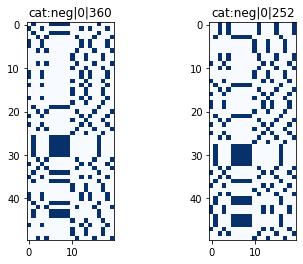

In [ ]:
make_heatmaps(
df_one=X_mut,
pred_score=predict_mut,
labels_cat=y_mut,
labels_cat_names=y_cat.columns,
size=2)


### Testing code for baseline
generates random mutation nt by nt along the binding site, taking and nesting the mirna within the in-silico random sequence.

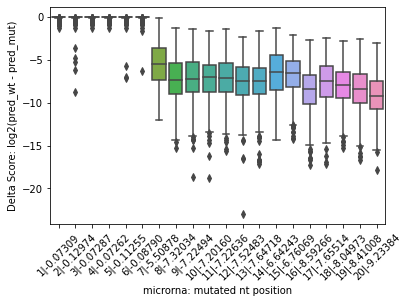

In [ ]:
# testing code for baseline

np.seterr(divide = 'ignore') 
predictions = list()
for i in range(1,21,1):
    # generate n random connections, WITH nest option set to TRUE:
    # the microrna sequence will be nested within the in-silico binding sequence
    if i <= 21:
        mirna_silico_mut = [ [
            random_mutation(mirna, start_mut=i, end_mut=i, p=1.)] * n_
                                for mirna in mirna_db_wt ]
    else:
        mirna_silico_mut = [ [
            random_mutation(mirna, start_mut=i, end_mut=i, p=0.)] * n_
                                for mirna in mirna_db_wt ]
    # mutate wt dataset to create the altereted dataset
    mirna_silico_mut = list(itertools.chain.from_iterable(mirna_silico_mut))
    connection_silico_mut = connection_silico_wt.copy()
    connection_silico_mut.mirna_binding_sequence = mirna_silico_mut.copy()
    X_mut, _ = one_hot_encoding(
        connection_silico_mut, tensor_dim=(50,20,1))
    predict_mut = model.predict(X_mut)
    predict_mut = predict_mut[ : , 1] # take only pred from pos class
    delta_score = np.log2(np.absolute( predict_wt - predict_mut )) # score diff for pos class only

    t = pd.DataFrame(delta_score, columns=["delta_score"])
    t["mut_pos"] = f'{i}|{delta_score.mean():.5f}'
    predictions.append(t)

df = pd.concat(predictions)
ax = sns.boxplot(data=df, x="mut_pos", y="delta_score")
ax.set(xlabel='microrna: mutated nt position', 
       ylabel='Delta Score: log2(pred_wt - pred_mut)')
plt.xticks(rotation=45)
plt.show()

# Run Pipeline

### Load Encori Dataset.

Load the train set derived from ENCORI database.

In [ ]:
ENCORI_PATH = './train_set_positives.tsv'

train_df = pd.read_csv(
    ENCORI_PATH, sep='\t',
    usecols=['familyseqRepresentative', 'pos_sequence'])
train_df['label'] = 'positive'
train_df.columns = [
                    'binding_sequence',
                    'mirna_binding_sequence',
                    'label'
                    ]

print(f'trainable encori samples are {train_df.shape}')
train_df.head(10)

trainable encori samples are (179148, 3)


,binding_sequence,mirna_binding_sequence,label
0,GCTTGGTCCTCAGGTATCTACCTCCCACCTTCTCCTCATCTGTGGA...,TGAGGTAGTAGGTTGTGTGG,positive
1,TGCTACCGCCACTAGCGCTGCTTCCACTGCTTCTACCTCCCCTCCC...,TGAGGTAGTAGGTTGTGTGG,positive
2,AGCGGGGCTTCTCCTGCCTCCATCACATCACAGAAGTACCTCCTGC...,TGAGGTAGTAGGTTGTGTGG,positive
3,AAAGAGAGGCATTGCCTGTCCTGTTACTACCTCGCAGCCTTACTAT...,TGAGGTAGTAGGTTGTGTGG,positive
4,GTAAAACAGGTGGATACCAACTACCTCGAAGCAAATTGGTGAAAGA...,TGAGGTAGTAGGTTGTGTGG,positive
5,CTACTGAAACAGATTTCATACCTCAGAATGTAAAAGAACTTACTGA...,TGAGGTAGTAGGTTGTGTGG,positive
6,GTATAGTTGTCTGCAAAGCTACCTCCAAAACATCCAGTGATTTCTT...,TGAGGTAGTAGGTTGTGTGG,positive
7,ATTAAAAAGAATCCAATTATGTTTACCTCAAAAGAACCTGTTTTTG...,TGAGGTAGTAGGTTGTGTGG,positive
8,AACTCTCTTTACCCTTTATGCCTGCCTACCTCTGTTGTTAGAGATG...,TGAGGTAGTAGGTTGTGTGG,positive
9,ATTTATGTTGTAGAGAAATAGAATTACCTCTATTCTTTGTTTTGCC...,TGAGGTAGTAGGTTGTGTGG,positive


### Create an unique miRNA sequence database.

The miRNA sequence database is subsequently used to create samples of the negative class.

In [ ]:
mirna_db = train_df.mirna_binding_sequence.unique().tolist()
str_exam = "\t".join(mirna_db[:5])
print(f'mirna sequences examples:\t{str_exam}')

mirna sequences examples:	TGAGGTAGTAGGTTGTGTGG	TGGAATGTAAAGAAGTATGT	TACCCTGTAGATCCGAATTT	TACAGTACTGTGATAACTGA	AGCAGCATTGTACAGGGCTA


### Standard training pipeline.

In [ ]:
# define number of positive samples to use for the model training
POSITIVE_SAMPLES = 1000
# define number of negative samples to generate for each positive sample
NEG_RATIO = 10
# set random state for reproducibility
RANDOM_STATE = 1789
np.random.seed(RANDOM_STATE)
# set working directory (models stored here)
WORK_DIR = "./models/train/standard/20K_10neg/"
# custom model name prefix
STRATEGY = "standard"
MODEL_ID = f'model_{STRATEGY}'
# create WORK_DIR if not exists
if not os.path.exists(WORK_DIR):
    os.makedirs(WORK_DIR)

#### Prepare the train dataset.

In [ ]:
# generate positive and negative samples
pos_df, neg_df, _ = generate_subsets(
    df=train_df, size=POSITIVE_SAMPLES, neg_ratio=NEG_RATIO, pos_df=None,
    update=True, random_state=RANDOM_STATE, mirna_list=mirna_db)
print(f'positive df size is: {pos_df.shape}\nnegative df size is:{neg_df.shape}')
# concateneta positive and negative samples into a unique dataframe
main_df = pd.concat([pos_df, neg_df])
main_df = main_df.sample(frac=1)
# convert the unique dataframe to one hot encoding
ohe_data = multithread(
            main_df, one_hot_encoding, n_cores=2
            )

main_df_ohe, label_ohe = ohe_data

positive df size is: (1000, 3)
negative df size is:(10000, 3)


#### Compile the model.

In [ ]:
model = compile_model(output_shape=1)
model.summary()

Model: "arch_00b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 50, 20, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 50, 20, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 20, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 20, 32)        128       
_________________________________________________________________
Max_1 (MaxPooling2D)         (None, 25, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 10, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 25, 10, 64)        184

#### Train the model.

In [ ]:
model_loss = model.fit(
    main_df_ohe, label_ohe,
    validation_split=0.05, epochs=10,
    batch_size=32
    )


Epoch 1/10
327/327 [==============================] - 35s 102ms/step - loss: 0.5153 - accuracy: 0.7662 - val_loss: 0.4010 - val_accuracy: 0.9200
Epoch 2/10
327/327 [==============================] - 33s 101ms/step - loss: 0.2902 - accuracy: 0.9007 - val_loss: 0.4645 - val_accuracy: 0.9200
Epoch 3/10
327/327 [==============================] - 33s 101ms/step - loss: 0.2174 - accuracy: 0.9189 - val_loss: 0.3909 - val_accuracy: 0.9200
Epoch 4/10
327/327 [==============================] - 33s 101ms/step - loss: 0.1660 - accuracy: 0.9365 - val_loss: 0.1670 - val_accuracy: 0.9273
Epoch 5/10
327/327 [==============================] - 33s 101ms/step - loss: 0.1339 - accuracy: 0.9462 - val_loss: 0.0591 - val_accuracy: 0.9764
Epoch 6/10
327/327 [==============================] - 33s 101ms/step - loss: 0.1156 - accuracy: 0.9554 - val_loss: 0.0495 - val_accuracy: 0.9782
Epoch 7/10
327/327 [==============================] - 34s 103ms/step - loss: 0.1020 - accuracy: 0.9618 - val_loss: 0.0445 - val_ac

## Iterative Dynamic Training.

### Define Iterative Train Paramenters
This section allows the user to define train paramenters:  
- POSITIVE_SAMPLES_SIZE: positive sample size for each iteration (int., def. 1000);
- NEG_RATIO: starting ratio for samples of the negative class (int., def. 1);
- RANDOM_STATE: set random state for reproducibility (int., def. 1789);
- CORES: available cores for train dataset pre-processing to ohe (int., def. 2);
- MINIBATCH_SPLIT: number of bins to divide the train dataset (int. def. 500);
- WORK_DIR: save data to PATH (str., def. cwd);
- STRATEGY: training strategy (str: iter or normal);
- MODEL_ID: arbitrary model name (str, def. model);
- MAX_ITER: set max number of iterations (int., def. 28);
- POS_THR: define threshold to claim a prediction as positive (float, def. 0.5)
- F1_TRIGGER: set threshold above that the negative ratio is increased (float, def. 0.7)




In [ ]:
POSITIVE_SAMPLES_SIZE = 1000
NEG_RATIO = 1
RANDOM_STATE = 1789
np.random.seed(RANDOM_STATE)
MINIBATCH_SPLIT = 500
CORES = 2
START_FROM_ITER = 0
MAX_ITER = 28
POS_THR = 0.5
F1_TRIGGER = 0.7

# set working directory (models stored here)
WORK_DIR = "./models/train/iterative/"
# custom model name prefix
STRATEGY = "iter"
MODEL_ID = f'model_{STRATEGY}'
# create WORK_DIR if not exists
if not os.path.exists(WORK_DIR):
    os.makedirs(WORK_DIR)

### Create Model

In [ ]:
model = compile_model(output_shape=1)

### Iterative Training

This cell defines the iterative training with incresing negative ratio scheme.

In [ ]:
from collections import defaultdict

# copy original data frame
main_df = train_df.copy()
# generate mirna database
mirna_db = main_df.mirna_binding_sequence.unique().tolist()
# initialize array for f1 and val loss metrics
iter_f1_score = np.zeros( (MAX_ITER, 1) )
iter_val_losses = np.zeros( (MAX_ITER, 1) )
# initialize negative ratio
iter_neg_ratio = NEG_RATIO
# tot pos samples counter
pos_counter = POSITIVE_SAMPLES_SIZE
# tot neg samples counter
neg_counter = 0

for iteration in tqdm(range(START_FROM_ITER, MAX_ITER), desc='iteration'):
    # define iteration's model name
    model_name = f'{WORK_DIR}/{iteration}.iterative.h5'
    # evaluate f1 score
    if (iter_f1_score[iteration - 1 ]) > F1_TRIGGER:
        # create train dataset by complete replacement
        iter_neg_ratio += 1
        pos_df, neg_df, main_df = generate_subsets(
            df=main_df, size=POSITIVE_SAMPLES_SIZE,
            neg_ratio=iter_neg_ratio, pos_df=None,
            update=True, random_state=RANDOM_STATE,
            mirna_list=mirna_db)
        pos_counter += pos_df.shape[0]

    else:
        # create train dataset by partial replacement
        pos_df, neg_df, main_df = generate_subsets(
            df=main_df, size=POSITIVE_SAMPLES_SIZE,
            neg_ratio=iter_neg_ratio, pos_df=pos_df,
            update=False, random_state=RANDOM_STATE,
            mirna_list=mirna_db
            )
    # update counter of used negative samples
    neg_counter += neg_df.shape[0]
    print(
        f'#\tstart training of iteration:\t{iteration}\t' +
        f'negative ratio is:\t{iter_neg_ratio}\t' +
        f'total used pos-neg:\t{pos_counter}\t{neg_counter}\t'
        )
    # prepare minibatches
    minibatches = make_minibatches(
        pos_df, neg_df, MINIBATCH_SPLIT
        )

    # create array where minibatch's losses are stored.
    batch_losses = np.zeros( (MINIBATCH_SPLIT, 1), dtype='float')
    for mini_index in tqdm(range(MINIBATCH_SPLIT), desc='minibatches'):
        minibatch = minibatches[mini_index]
        minibatch = minibatch.sample(frac=1)
        # minibatches to ohe generator
        ohe_data = multithread(
            minibatch, one_hot_encoding, n_cores=CORES
            )
        if mini_index == MINIBATCH_SPLIT - 1:
            # get val metrics
            val_metrics = model.test_on_batch(
                { "main_input" : ohe_data[0]},
                { "main_output" : ohe_data[1]}
                )
            iter_val_losses[iteration] = val_metrics[0]
            # get val f1 score
            f1 = eval_f1(
                        model, ohe_data,
                        pos_thr=POS_THR,
                        save=True,
                        fname=model_name
                        )
            # add val f1 score
            iter_f1_score[iteration] = f1
            # get minibatches average train loss
            avg_loss = np.average(batch_losses)
            
            print(
                f'train loss:\t{round(avg_loss, 8)}\t' +
                f'val loss:\t{round(val_metrics[0], 8)}\t' +
                f'val f1:{round(f1, 8)}'
                )

        else:
            # train model
            model, batch_loss = train( model, ohe_data, reset_metrics=True )
            # add loss
            batch_losses[mini_index] = batch_loss[0]

iteration:   0%|          | 0/28 [00:00<?, ?it/s]

#	start training of iteration:	0	negative ratio is:	1	total used pos-neg:	1000	1000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.71430926	val loss:	1.08345675	val f1:0.0
#	start training of iteration:	1	negative ratio is:	1	total used pos-neg:	1000	2000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.57198973	val loss:	0.77728307	val f1:0.66666667
#	start training of iteration:	2	negative ratio is:	1	total used pos-neg:	1000	3000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.42966793	val loss:	0.59069324	val f1:0.66666667
#	start training of iteration:	3	negative ratio is:	1	total used pos-neg:	1000	4000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.35705406	val loss:	0.57104617	val f1:0.66666667
#	start training of iteration:	4	negative ratio is:	1	total used pos-neg:	1000	5000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.27145432	val loss:	0.33083662	val f1:0.66666667
#	start training of iteration:	5	negative ratio is:	1	total used pos-neg:	1000	6000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.21284312	val loss:	0.41645527	val f1:0.66666667
#	start training of iteration:	6	negative ratio is:	1	total used pos-neg:	1000	7000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.15348897	val loss:	0.43087733	val f1:0.66666667
#	start training of iteration:	7	negative ratio is:	1	total used pos-neg:	1000	8000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.12478037	val loss:	0.00773461	val f1:1.0
#	start training of iteration:	8	negative ratio is:	2	total used pos-neg:	2000	10000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.16184066	val loss:	0.4104501	val f1:0.8
#	start training of iteration:	9	negative ratio is:	3	total used pos-neg:	3000	13000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.13979246	val loss:	0.0778562	val f1:1.0
#	start training of iteration:	10	negative ratio is:	4	total used pos-neg:	4000	17000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.12092663	val loss:	0.05286001	val f1:1.0
#	start training of iteration:	11	negative ratio is:	5	total used pos-neg:	5000	22000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.10616172	val loss:	0.04383306	val f1:1.0
#	start training of iteration:	12	negative ratio is:	6	total used pos-neg:	6000	28000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.09418317	val loss:	0.03874239	val f1:1.0
#	start training of iteration:	13	negative ratio is:	7	total used pos-neg:	7000	35000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.08931311	val loss:	0.07315807	val f1:1.0
#	start training of iteration:	14	negative ratio is:	8	total used pos-neg:	8000	43000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.07468847	val loss:	0.22952244	val f1:0.8
#	start training of iteration:	15	negative ratio is:	9	total used pos-neg:	9000	52000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.07163556	val loss:	0.07395206	val f1:0.8
#	start training of iteration:	16	negative ratio is:	10	total used pos-neg:	10000	62000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.07090819	val loss:	0.01930011	val f1:1.0
#	start training of iteration:	17	negative ratio is:	11	total used pos-neg:	11000	73000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.06221073	val loss:	0.04394684	val f1:1.0
#	start training of iteration:	18	negative ratio is:	12	total used pos-neg:	12000	85000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.06257169	val loss:	0.0163058	val f1:1.0
#	start training of iteration:	19	negative ratio is:	13	total used pos-neg:	13000	98000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.05557656	val loss:	0.00684013	val f1:1.0
#	start training of iteration:	20	negative ratio is:	14	total used pos-neg:	14000	112000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.0501065	val loss:	0.00328759	val f1:1.0
#	start training of iteration:	21	negative ratio is:	15	total used pos-neg:	15000	127000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.04873873	val loss:	0.10234323	val f1:0.66666667
#	start training of iteration:	22	negative ratio is:	15	total used pos-neg:	15000	142000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.0441202	val loss:	0.14432025	val f1:0.66666667
#	start training of iteration:	23	negative ratio is:	15	total used pos-neg:	15000	157000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.04351445	val loss:	0.12946729	val f1:0.66666667
#	start training of iteration:	24	negative ratio is:	15	total used pos-neg:	15000	172000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.04056966	val loss:	0.22423361	val f1:0.66666667
#	start training of iteration:	25	negative ratio is:	15	total used pos-neg:	15000	187000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.03569116	val loss:	0.14689587	val f1:0.66666667
#	start training of iteration:	26	negative ratio is:	15	total used pos-neg:	15000	202000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.03311211	val loss:	0.19952291	val f1:0.66666667
#	start training of iteration:	27	negative ratio is:	15	total used pos-neg:	15000	217000	


minibatches:   0%|          | 0/500 [00:00<?, ?it/s]

train loss:	0.03041445	val loss:	0.17513072	val f1:0.66666667
